In [1]:
import numpy as np 
import copy
import scalelens as sl
from lenstronomy.LensModel.lens_model import LensModel
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from scipy import integrate
from pyHalo.Halos.lens_cosmo import LensCosmo
from lenstronomy.LensModel.Profiles.nfw import NFW 
from lenstronomy.LensModel.Profiles.uldm import Uldm 
from num2tex import num2tex
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# lens
uldmModel = LensModel(['ULDM'])
nfwModel = LensModel(['NFW'])
bothModel = LensModel(['ULDM','NFW'])

# NFW params
Rs = 0.1
alpha_Rs = 0.01
kwargs_nfw = {'Rs':Rs,'alpha_Rs':alpha_Rs,'center_x':0,'center_y':0}

# ULDM params
kappaRef = sl.kappa_ref(nfwModel,kwargs_nfw)
kappa_0 = kappaRef*1.0
theta_c = Rs/2
kwargs_uldm = {'kappa_0':kappa_0,'theta_c':theta_c,'center_x':0,'center_y':0}

In [3]:
# Compute scale factor for given Rmax
Rmax = Rs*10.0
factor = sl.rescale_NFW(Rmax,kwargs_nfw,kwargs_uldm)

The above scaling factor, $f_{scale},$ is only applied to $\alpha_{R_s}$ since the mass of the NFW profile depends on $\alpha_{R_s}$ linearly, unlike $R_s:$ 

$$ M_{NFW}(r) \propto \alpha_{R_s}R_s\left[\log\left(\frac{R_s+r}{R_s}\right)-\frac{r}{R_s+r}\right].$$

The scaling factor is given by

$$ f_{scale} = \frac{M_{NFW}(r\leq R_{max})-M_{ULDM}(r\leq R_{max})}{M_{NFW}(r\leq R_{max})}.$$

In [4]:
# Compute masses of NFW and NFW+ULDM profiles as functions of radius while conserving mass
r = np.linspace(10**-1,10**2,10**4) # in units of Rs

nfw = NFW()
uldm = Uldm()

mass_NFW = np.array([nfw.mass_3d_lens(ri*Rs,kwargs_nfw['Rs'],kwargs_nfw['alpha_Rs']) for ri in r])
mass_NFW_comp = np.array([nfw.mass_3d_lens(ri*Rs,kwargs_nfw['Rs'],kwargs_nfw['alpha_Rs']*factor) for ri in r])
mass_ULDM = np.array([uldm.mass_3d_lens(ri*Rs,kwargs_uldm['kappa_0'],kwargs_uldm['theta_c']) for ri in r])
mass_comp = mass_ULDM+mass_NFW_comp

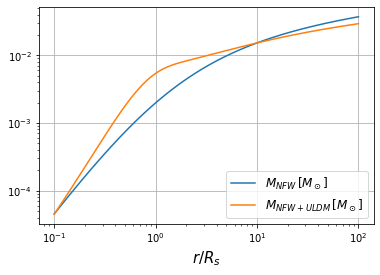

In [5]:
# Plot the mass curves
plt.loglog(r,mass_NFW,label=r'$M_{NFW}\,[M_\odot]$')
plt.loglog(r,mass_comp,label=r'$M_{NFW + ULDM}\,[M_\odot]$')
plt.legend(fontsize=12,loc='lower right')
plt.xlabel('$r/R_s$',fontsize=15)
plt.grid(True)
plt.show()

As expected, we observe that the NFW and NFW + ULDM profiles have equal masses at $R_{max}=10R_s.$ With this approach, we cannot enforce mass conservation for arbitrarily small radii. The subsequent plot demonstrates that as $R_{max}\to O(R_s),$ the ULDM component of the composite profile is too dense to enforce mass conservation, hence $f_{scale}(R_{max}\sim O(R_s))<0.$

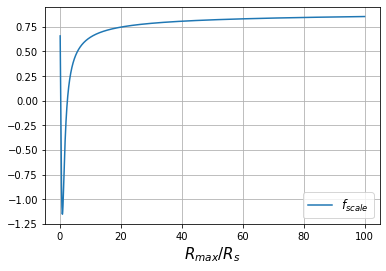

In [6]:
factors = [sl.rescale_NFW(Rmax*Rs,kwargs_nfw,kwargs_uldm) for Rmax in r]

plt.plot(r,factors,label=r'$f_{scale}$')
plt.legend(fontsize=12)
plt.xlabel('$R_{max}/R_s$',fontsize=15)
plt.grid(True)
plt.show()

We may now compute the convergence and deflection angles resulting from NFW and NFW + ULDM profiles with the above mass constraint.

In [7]:
# First compute the NFW kappas and alphas
kappas_NFW = [nfwModel.kappa(r,0,[kwargs_nfw]) for r in r]
alphas_NFW = [np.array(nfwModel.alpha(r,0,[kwargs_nfw]))[0] for r in r]

In [8]:
# Compute composite kappas and alphas, for varying Rmax and theta_c, kappa_0 is left constant

kappa_0 = kappaRef*1.5
Rmaxs = np.logspace(0.4,1,6) # in Rs units
factors = [sl.rescale_NFW(Rmax*Rs,kwargs_nfw,kwargs_uldm) for Rmax in Rmaxs]
theta_cs = np.logspace(-1,-0.1,10) # in Rs units

kappas_comp = np.zeros([len(factors),len(theta_cs),len(r)])
alphas_comp = np.zeros_like(kappas_comp)

for i in tqdm(range(len(factors))):
    for j in range(len(theta_cs)):
        for k in range(len(r)):
            kwargs = [{'kappa_0':kappa_0,'theta_c':theta_cs[j]*Rs, 'center_x':0, 'center_y':0}
                      ,{'Rs':Rs, 'alpha_Rs':alpha_Rs*factors[i], 'center_x':0, 'center_y':0}]
            kappas_comp[i][j][k] = bothModel.kappa(r[k],0,kwargs)
            alphas_comp[i][j][k] = np.array(bothModel.alpha(r[k],0,kwargs))[0]

100%|██████████| 6/6 [02:24<00:00, 24.05s/it]


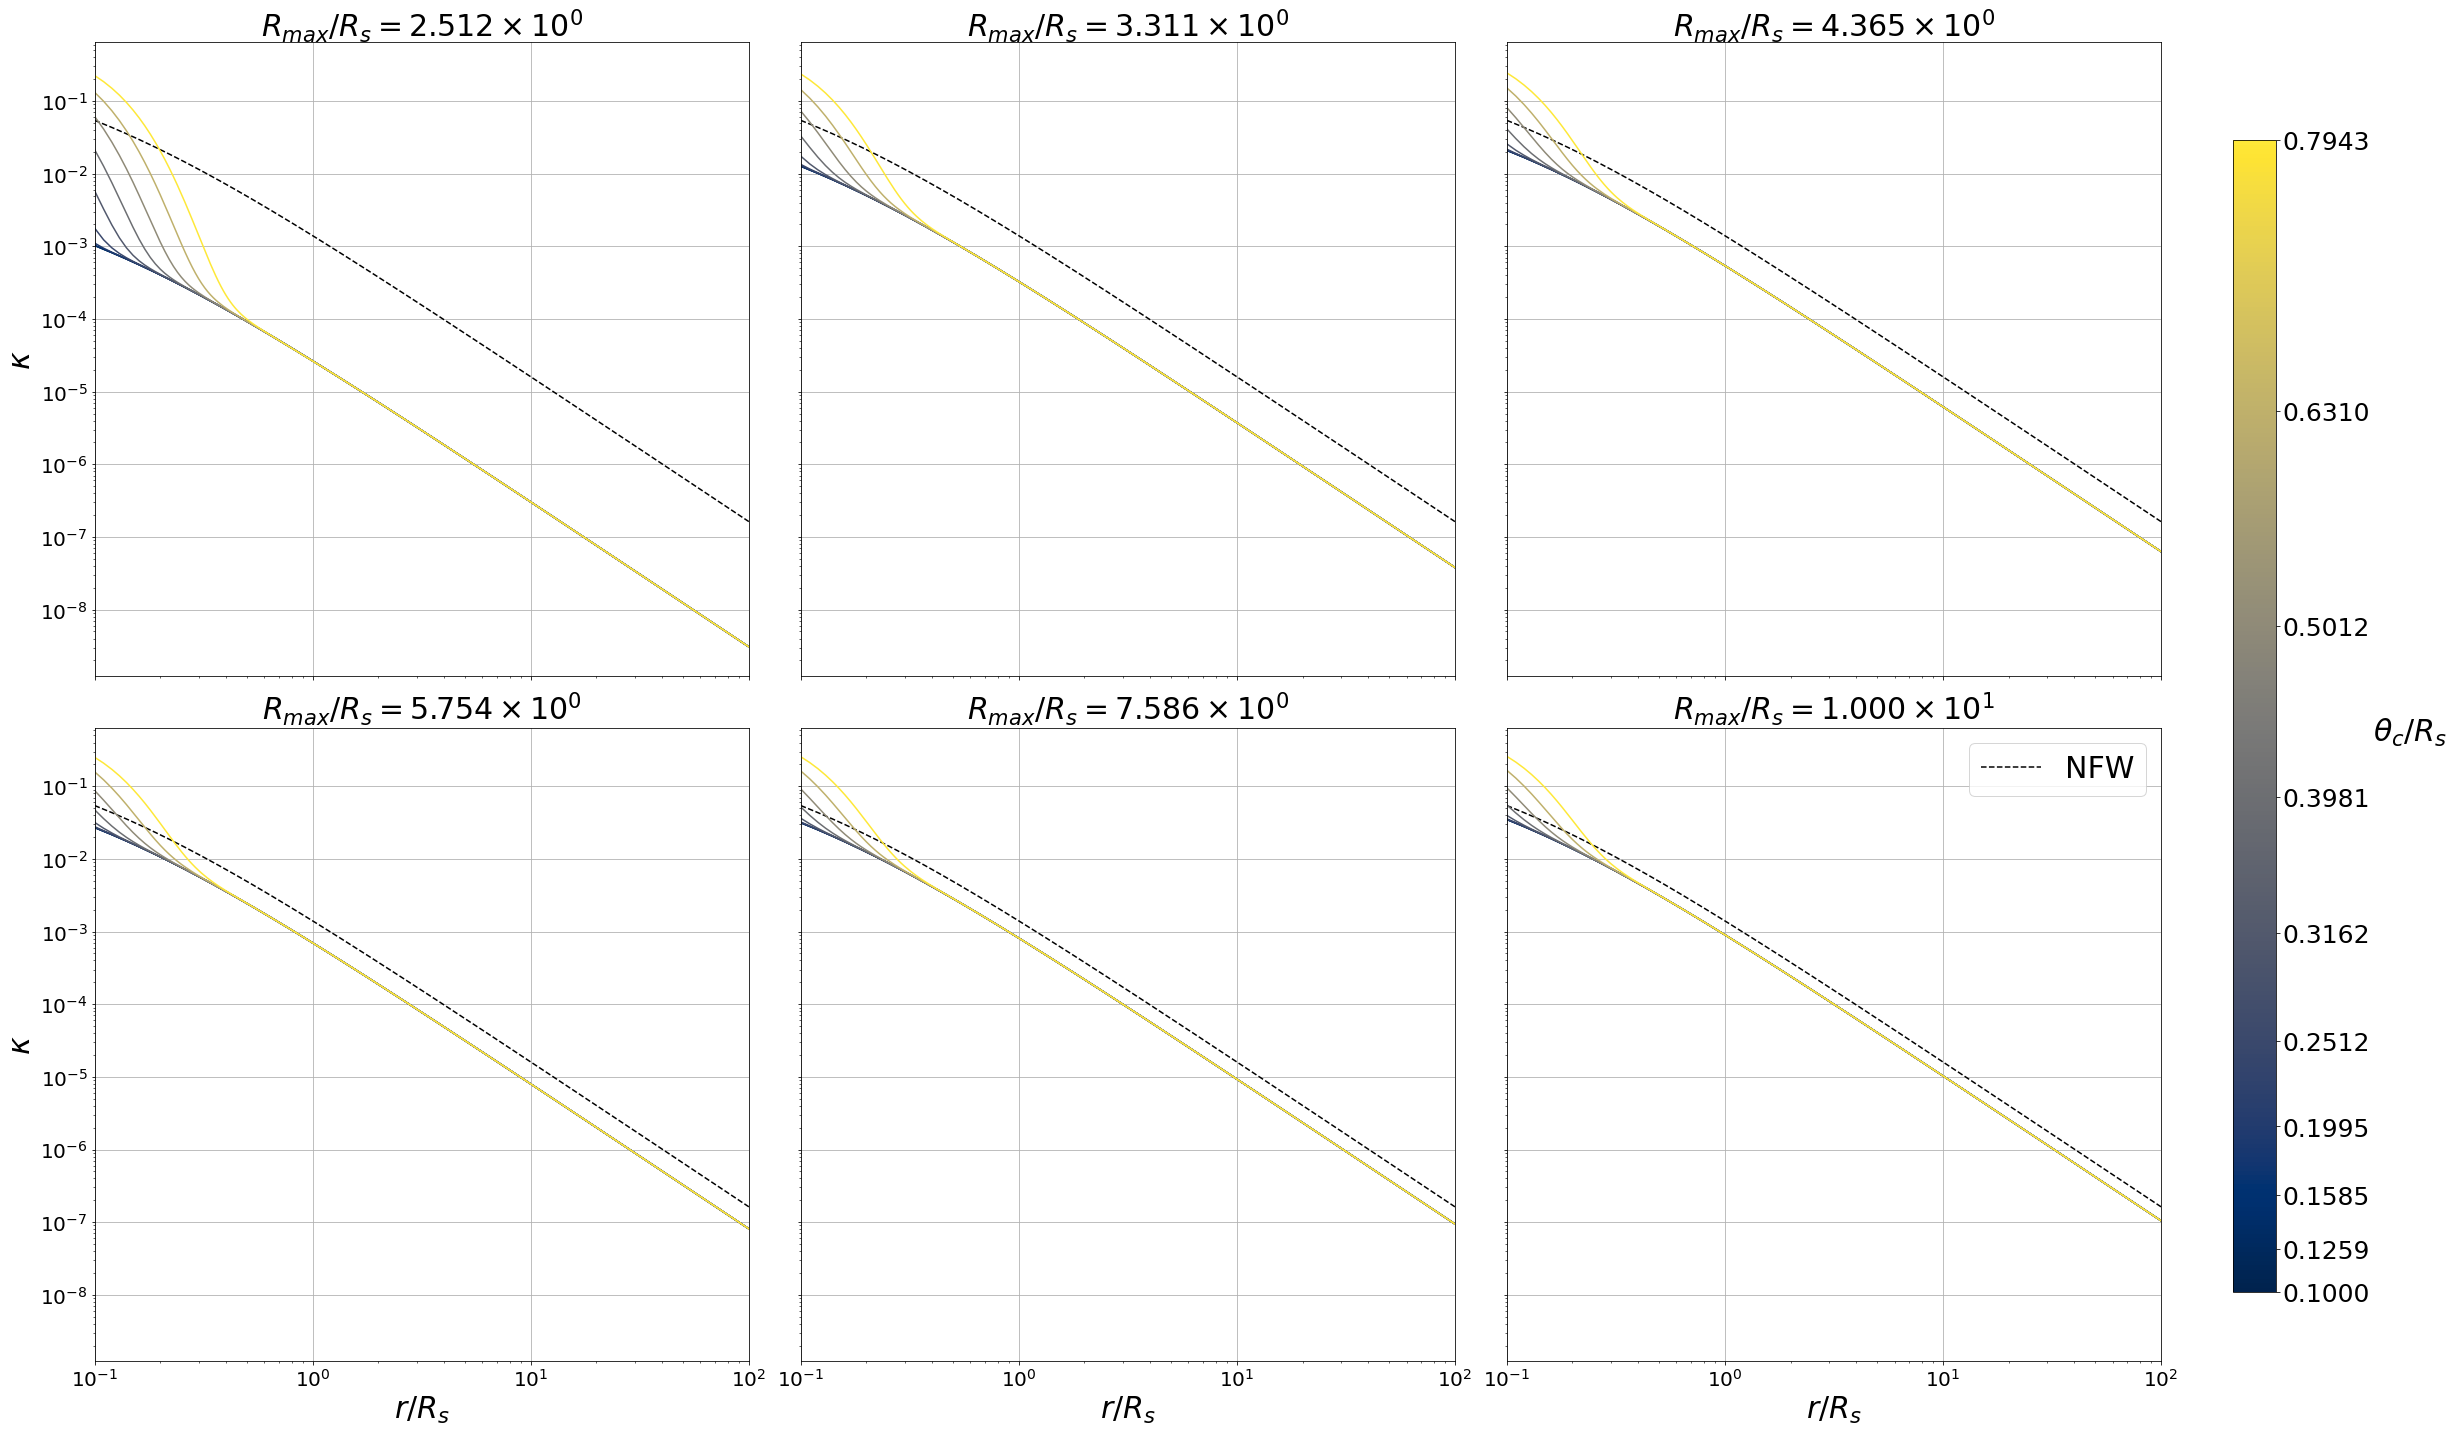

In [9]:
# plot kappas
sl.plot_stuff(r,kappas_comp,kappas_NFW,Rmaxs,theta_cs,r'$\kappa$',r'$\theta_c/R_s$','scaled_convergence')

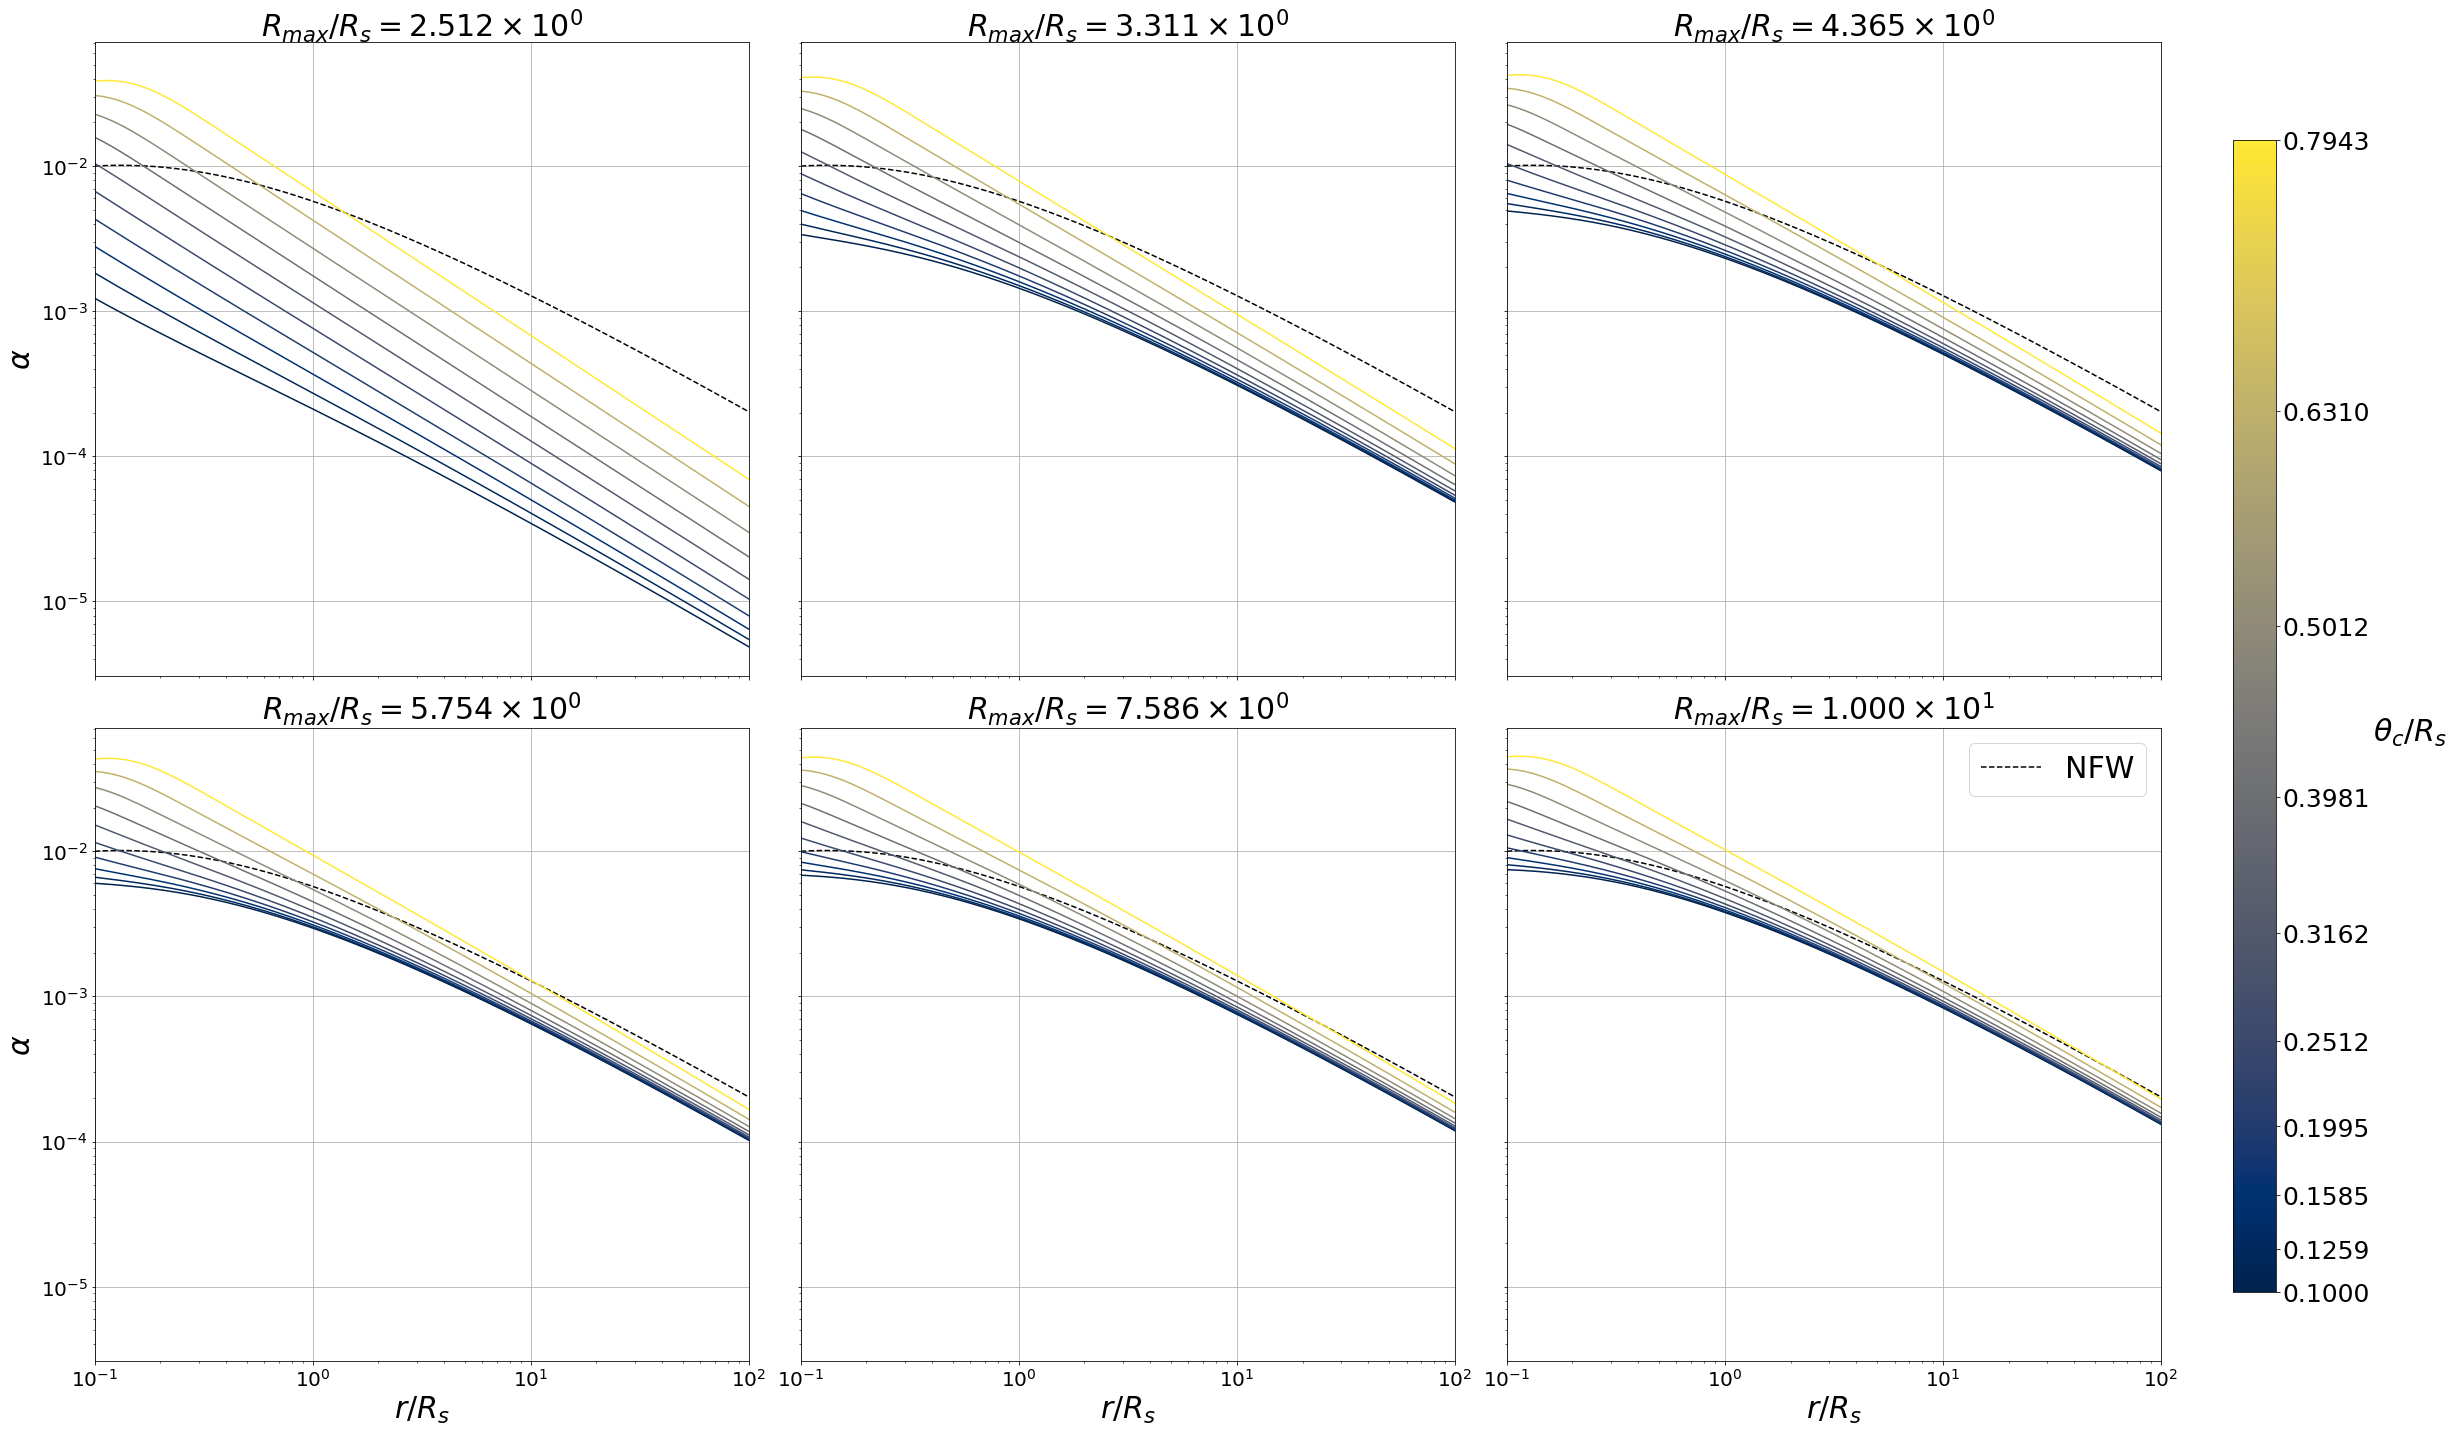

In [10]:
# plot alphas
sl.plot_stuff(r,alphas_comp,alphas_NFW,Rmaxs,theta_cs,r'$\alpha$',r'$\theta_c/R_s$','scaled_deflection_angles')

We might also want to be able to tune the mass ratios of the ULDM & NFW profiles. If we want the ULDM to compose a certain fraction of the total composite mass within $R_{max},$ we may tune $\kappa_0.$ Similarly to the NFW profile, $M_{ULDM}$ is non-linear in $\theta_c,$ so we opt to scale $\kappa_0.$ Specifically, we are solving for

$$ \tilde{f}_{scale} = \frac{M_{NFW}}{M_{ULDM}}X,$$

where $X$ is the desired ULDM mass fraction. We may set $\theta_c$ to be some fraction of $R_s,$ and subsequently correct the mass ratio. 

In [11]:
# NFW params
Rs = 0.1
alpha_Rs = 0.01
kwargs_nfw = {'Rs':Rs,'alpha_Rs':alpha_Rs,'center_x':0,'center_y':0}

# ULDM params
kappaRef = sl.kappa_ref(nfwModel,kwargs_nfw)
kappa_0 = kappaRef*1.0
theta_c = Rs/2
kwargs_uldm = {'kappa_0':kappa_0,'theta_c':theta_c,'center_x':0,'center_y':0}

# Choose Rmax
Rmax = 2*Rs

# Compute factor and apply to kappa_0 such that the ULDM profile accounts for 70% of the composite profile mass
uldm_factor = sl.tune_ULDM_mass(0.9,Rmax,kwargs_nfw,kwargs_uldm)
kwargs_uldm_scaled = {'kappa_0':kappa_0*uldm_factor,'theta_c':theta_c,'center_x':0,'center_y':0}

In [12]:
# Compute NFW scaling factor (and apply) after applying the ULDM scaling factor
nfw_factor = sl.rescale_NFW(Rmax,kwargs_nfw,kwargs_uldm_scaled)
kwargs_nfw_scaled = {'Rs':Rs,'alpha_Rs':alpha_Rs*nfw_factor,'center_x':0,'center_y':0}

In [13]:
# Compute the individual ULDM and NFW masses
uldm_comp_mass = uldm.mass_3d_lens(Rmax,kwargs_uldm_scaled['kappa_0'],kwargs_uldm_scaled['theta_c'])
nfw_comp_mass = nfw.mass_3d_lens(Rmax,kwargs_nfw_scaled['Rs'],kwargs_nfw_scaled['alpha_Rs'])

To check that everything is working, we expect the total mass ratio to be unity and the ULDM mass ratio to be $\tilde{f}_{scale}=0.9,$ within $R_{max}$.

In [14]:
# We expect the total ratio to be unity and the uldm to original NFW ratio to be the 0.9 (within Rmax)
nfw_mass = nfw.mass_3d_lens(Rmax,kwargs_nfw['Rs'],kwargs_nfw['alpha_Rs'])
total_ratio = (uldm_comp_mass + nfw_comp_mass)/nfw_mass
uldm_ratio = uldm_comp_mass/nfw_mass

print('total ratio: ' + str(total_ratio))
print('ULDM ratio: ' + str(uldm_ratio))

total ratio: 1.0
ULDM ratio: 0.8999999999999999


We may now freely tune the NFW/ULDM mass ratio. To summarize, the steps are as follows:

1) Select a NFW profile and a ULDM profile. The NFW profile one selects is the original NFW profile upon which the composite profile is based. The parameters that are set (for the composite profile) during this step are $R_s,$ for the NFW profile, and $\theta_c,$ for the ULDM profile. Both $\alpha_{R_s}$ and $\kappa_0$ will be tuned in subsequent steps.
    
2) Choose the ULDM mass fraction of the composite profile, compute the corresponding scaling factor and apply it to $\kappa_0.$ The mass equivalence radius, $R_{max},$ is set here.

3) 'Fill up' the rest of the composite mass with the NFW profile, so that the ULDM + NFW profile has an equivalent mass to the original NFW profile, within the $R_{max}$ that was just chosen. This is accomplished by computing a scaling factor for $\alpha_{R_s}.$

The end result is a NFW + ULDM profile with a specified mass ratio which has an equivalent mass to the original NFW profile within some radius. The above has been combined into a single function: nfw_uldm_profile.

In [15]:
# NFW params
Rs = 0.1
alpha_Rs = 0.01
kwargs_nfw = {'Rs':Rs,'alpha_Rs':alpha_Rs,'center_x':0,'center_y':0}

# ULDM params
kappaRef = sl.kappa_ref(nfwModel,kwargs_nfw)
kappa_0 = kappaRef*1.0
theta_c = Rs/2
kwargs_uldm = {'kappa_0':kappa_0,'theta_c':theta_c,'center_x':0,'center_y':0}

# Other params
Rmax = 1.5*Rs
uldm_frac = 0.8

# scale params
kwargs_nfw_scaled, kwargs_uldm_scaled = sl.nfw_uldm_profile(Rmax,uldm_frac,kwargs_nfw,kwargs_uldm)

We will now vary the mass ratio for the ULDM + NFW profile for a few $R_{max}.$

In [16]:
# Compute composite kappas and alphas, for varying Rmax and mass ratios (with the above NFW & ULDM kwargs)

Rmaxs = np.logspace(0.4,1,6) # in Rs units
uldm_fracs = (np.arange(10)+1)*0.1

kappas_comp = np.zeros([len(Rmaxs),len(uldm_fracs),len(r)])
alphas_comp = np.zeros_like(kappas_comp)

for i in tqdm(range(len(Rmaxs))):
    for j in range(len(uldm_fracs)):
        for k in range(len(r)):
            kwargs =  sl.nfw_uldm_profile(Rmaxs[i],uldm_fracs[j],kwargs_nfw,kwargs_uldm)
            kappas_comp[i][j][k] = bothModel.kappa(r[k],0,kwargs)
            alphas_comp[i][j][k] = np.array(bothModel.alpha(r[k],0,kwargs))[0]

100%|██████████| 6/6 [03:18<00:00, 33.08s/it]


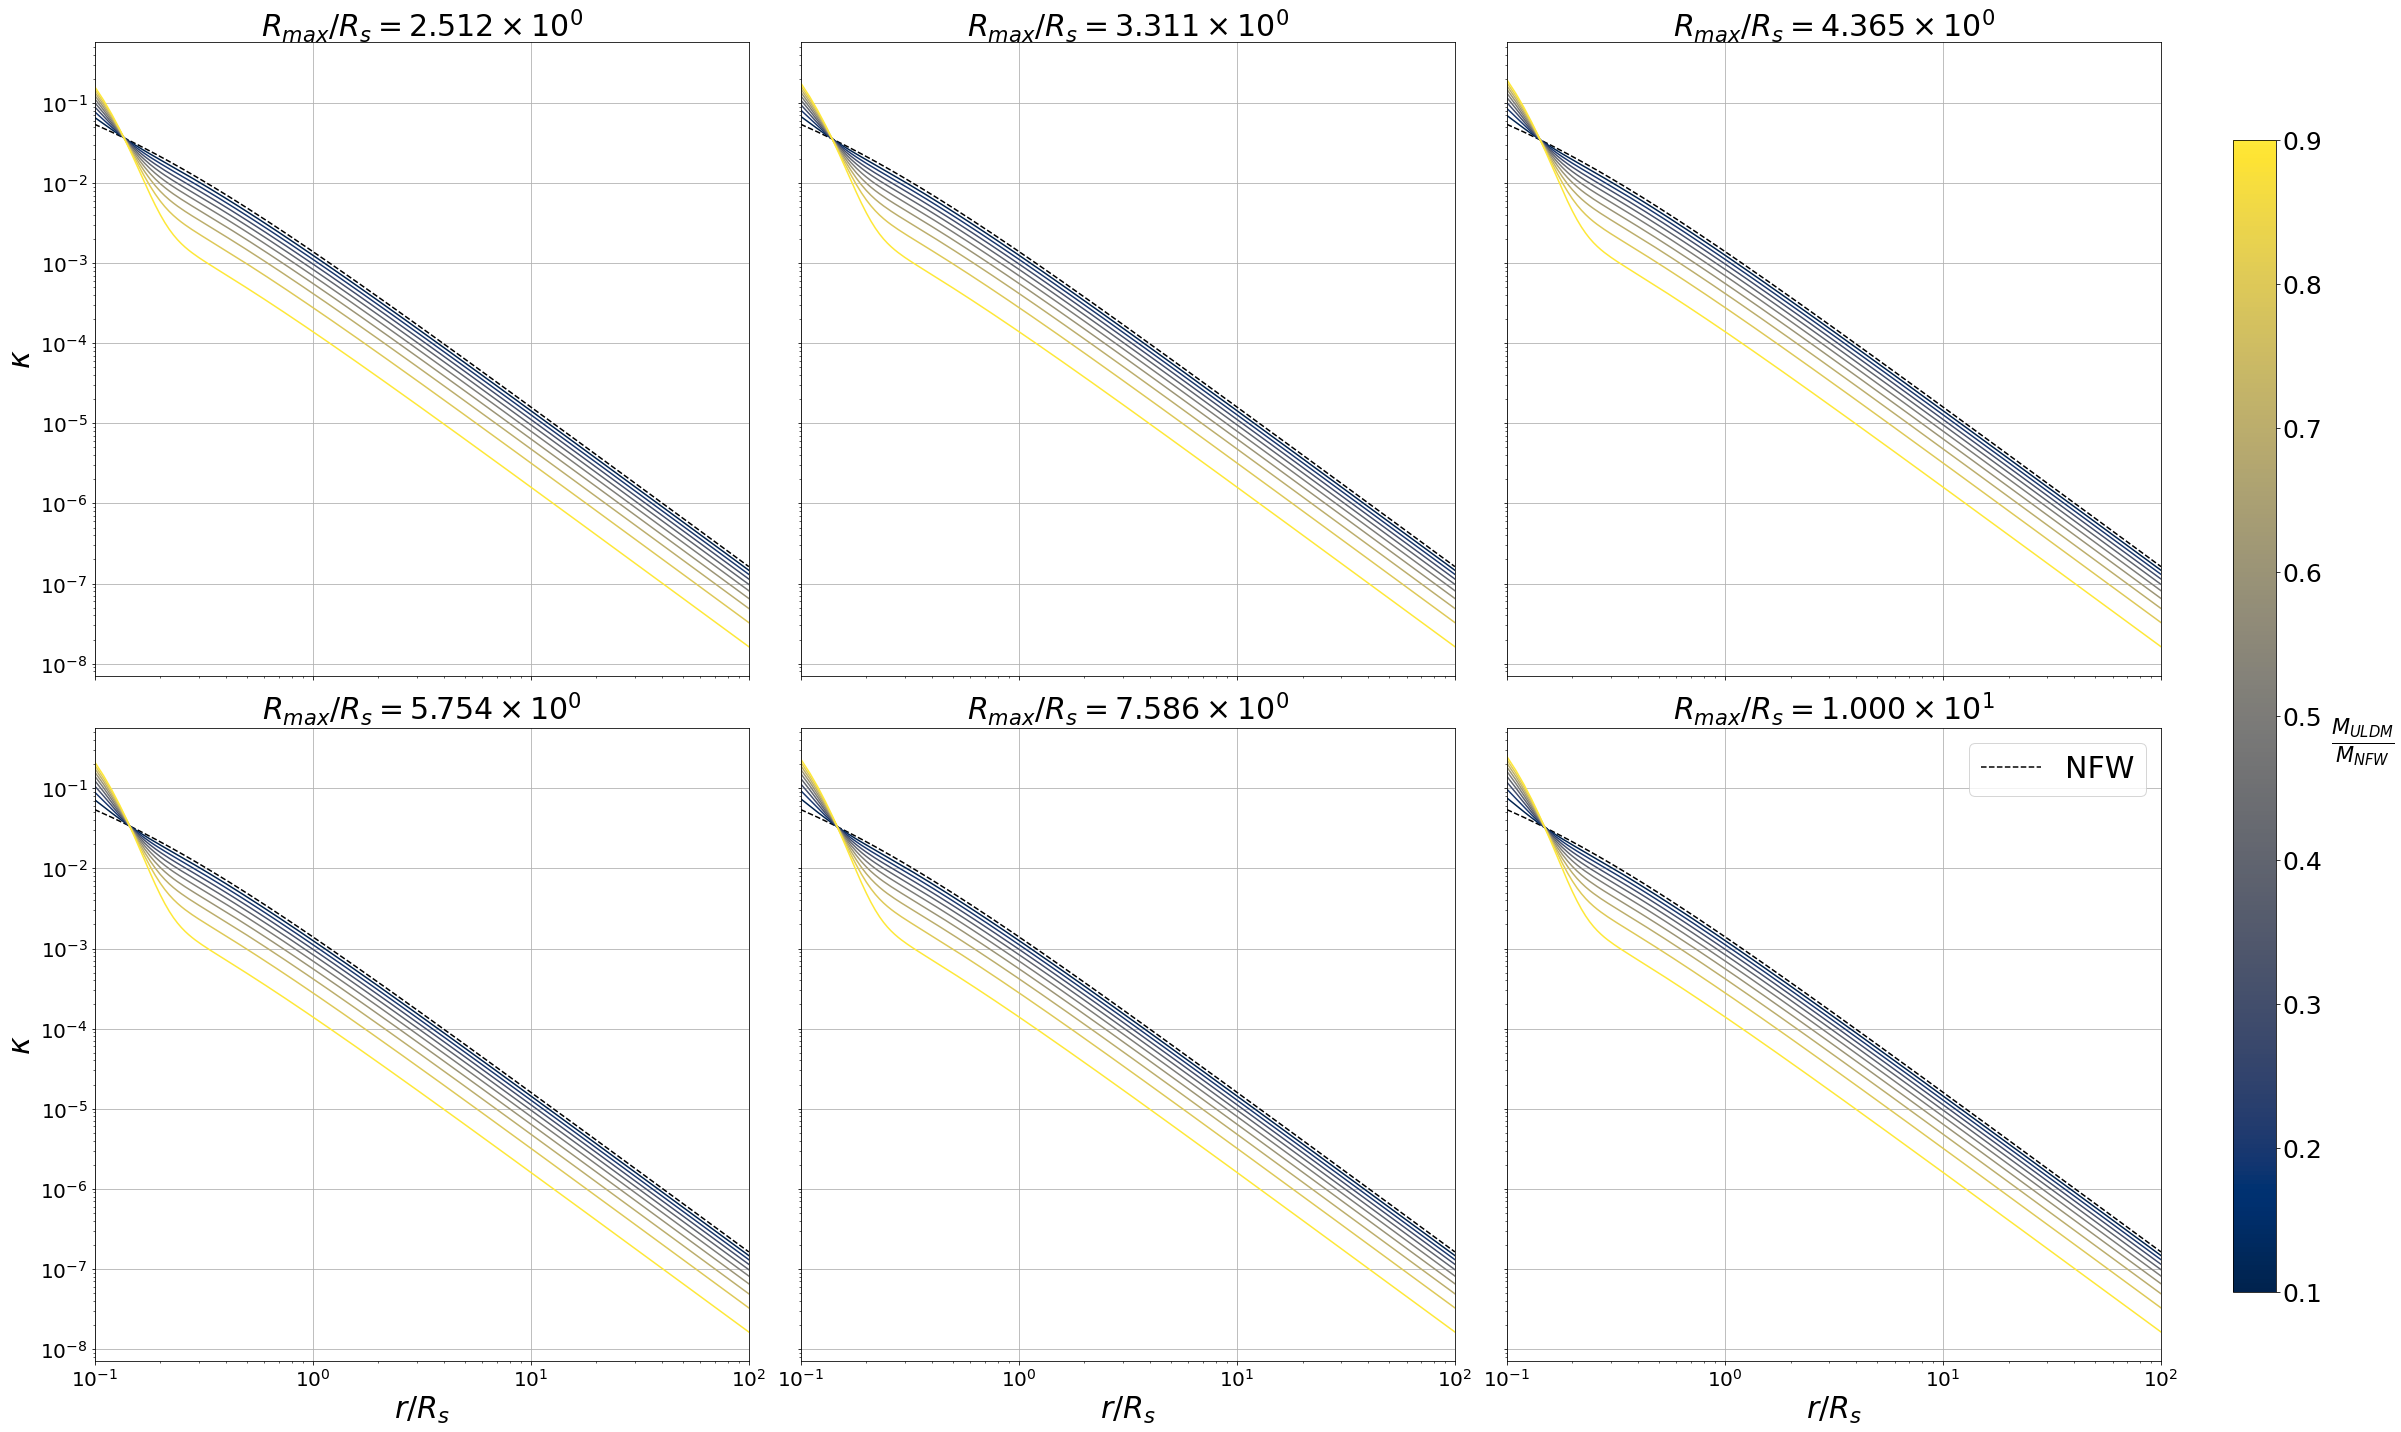

In [17]:
# plot kappas
sl.plot_stuff(r,kappas_comp,kappas_NFW,Rmaxs,uldm_fracs[:9],r'$\kappa$'
              ,r'$\frac{M_{ULDM}}{M_{NFW}}$','mass_ratio_convergence')

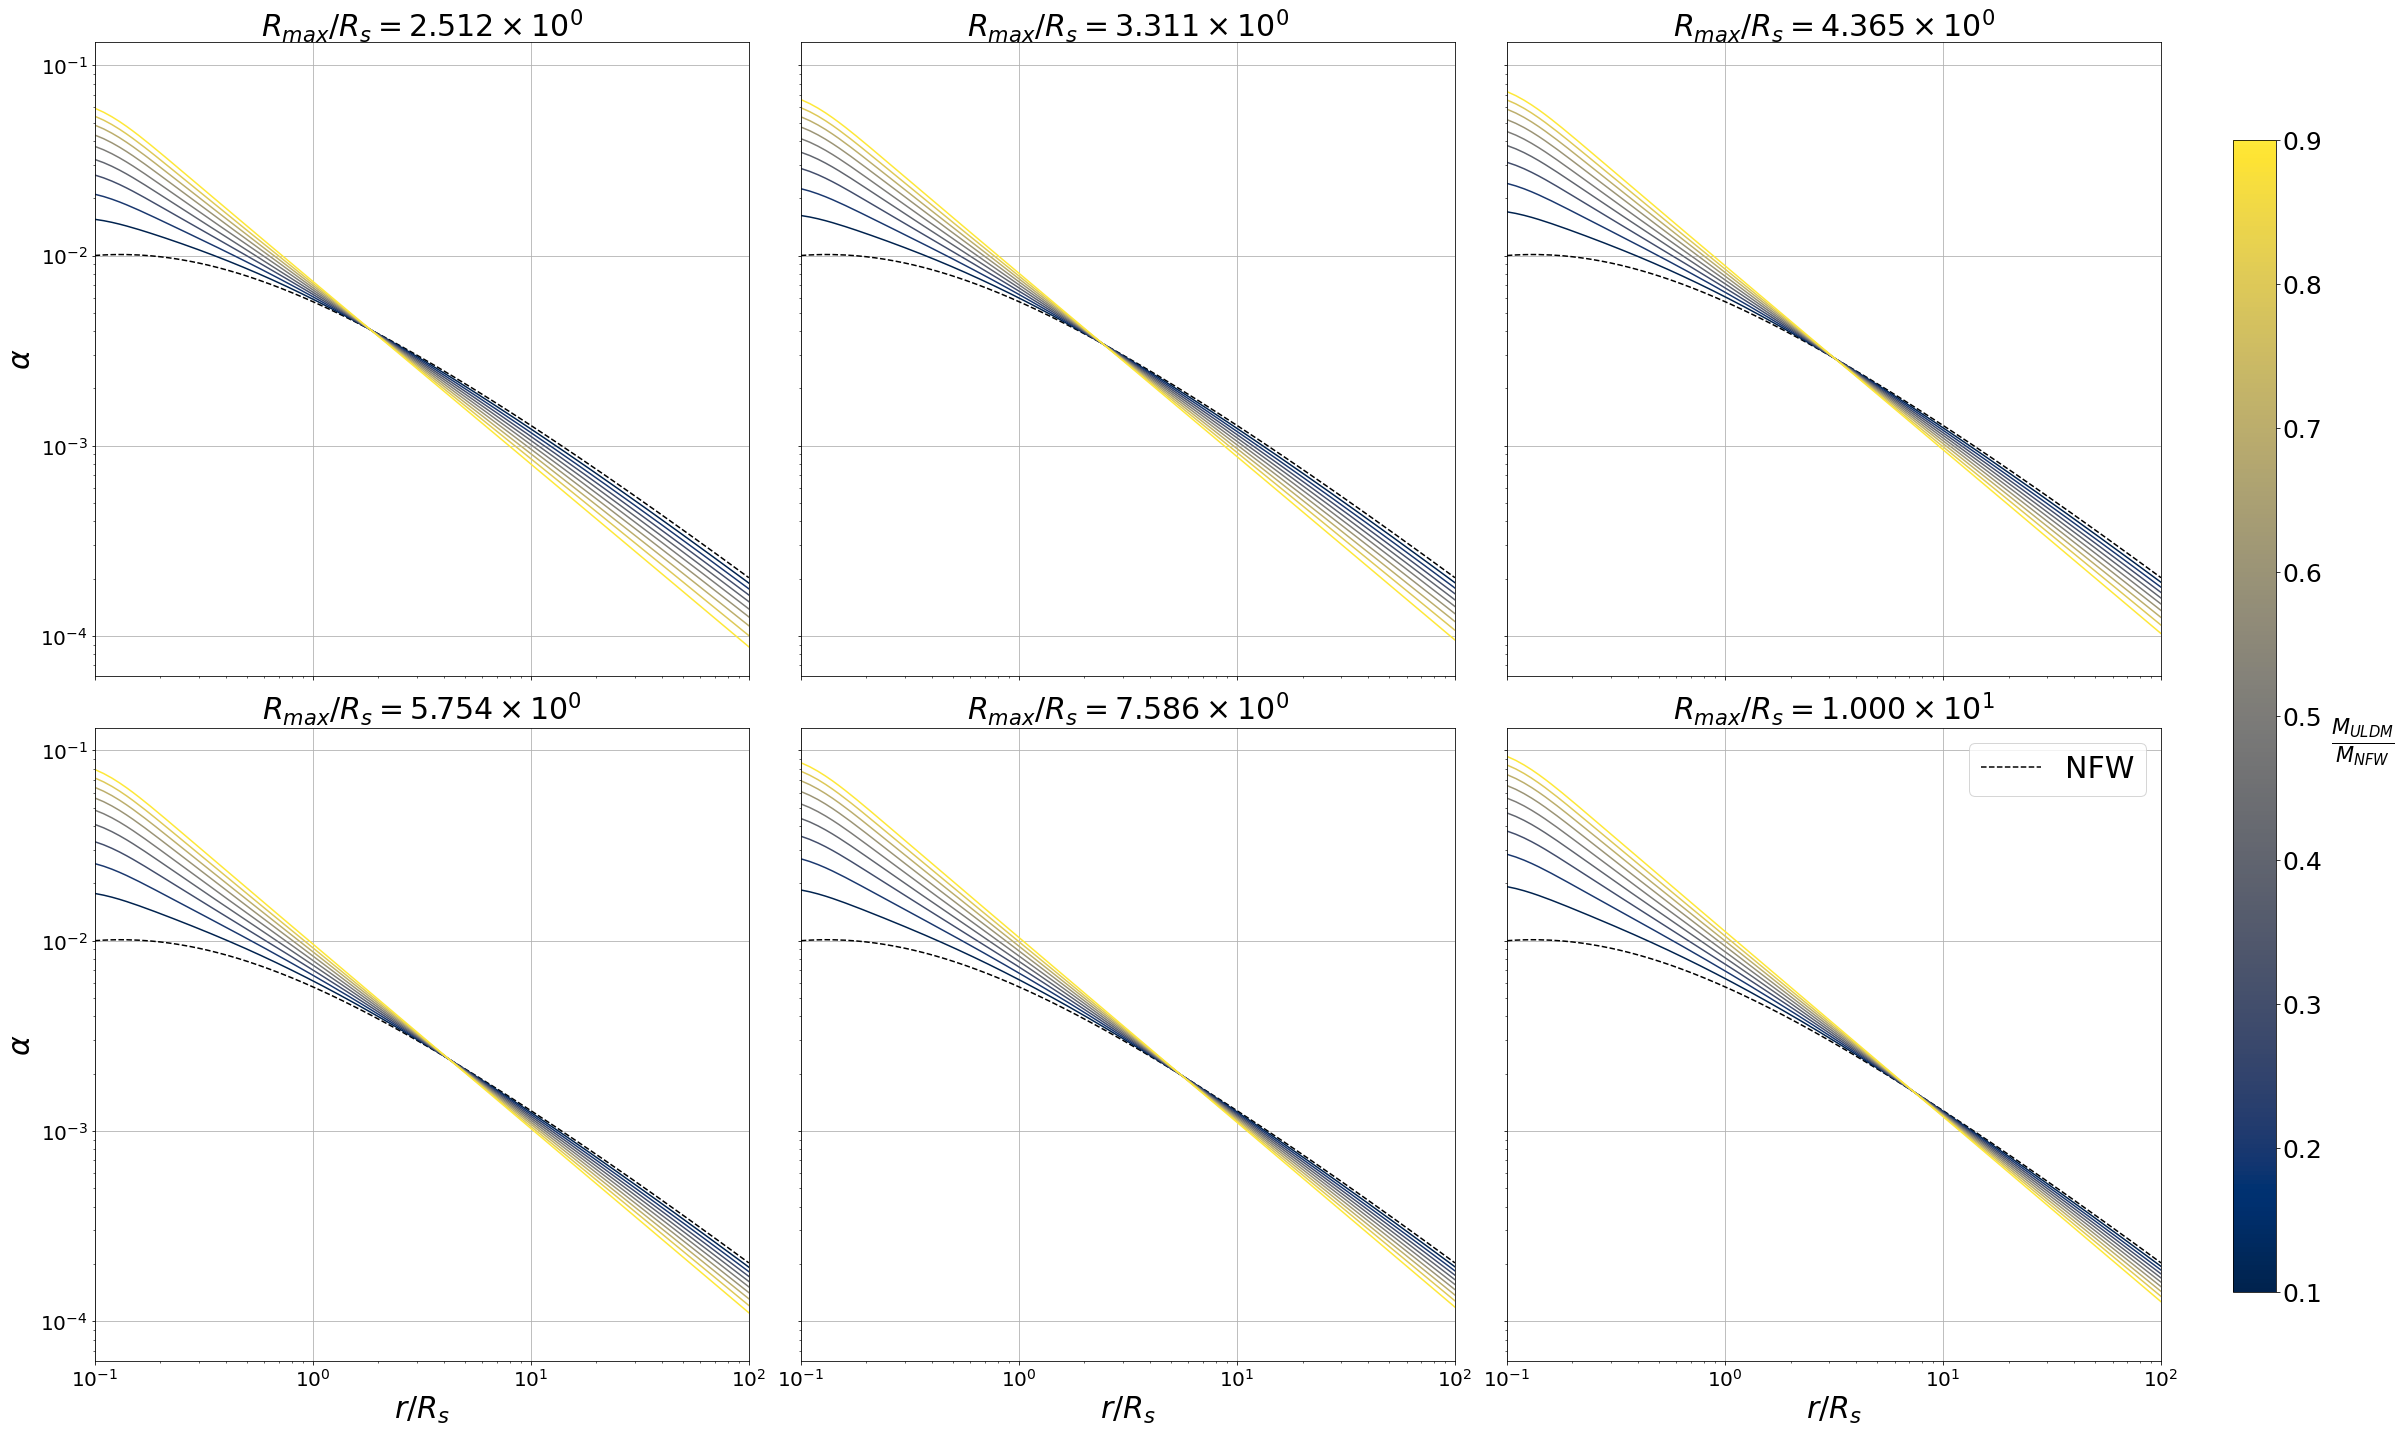

In [18]:
# plot alphas
sl.plot_stuff(r,alphas_comp,alphas_NFW,Rmaxs,uldm_fracs[:9],r'$\alpha$'
              ,r'$\frac{M_{ULDM}}{M_{NFW}}$','mass_ratio_deflection_angles')